# Time Series analysis


I this notebook I will be analysing the US unemployment data from 2010-2020 using techniques like ARIMA.

In [107]:
import pandas as pd
import nasdaqdatalink
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import config

# get API key from config.py
api_key = config.NASDAQ

nasdaqdatalink.ApiConfig.api_key = api_key

df_unem = (  nasdaqdatalink.get(dataset="FRED/UNRATENSA",
        start_date="2010-01-01",
        end_date="2019-12-31")
        .rename(columns={"Value": "unemp_rate"}))


<Axes: title={'center': 'Unemployment Rate'}, xlabel='Year', ylabel='Rate'>

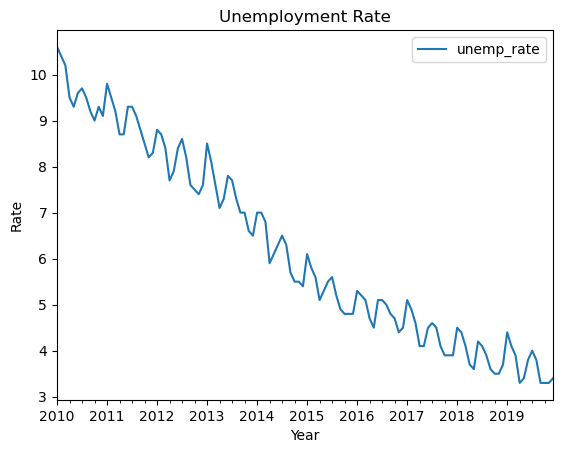

In [108]:
df_unem.plot(title='Unemployment Rate',ylabel='Rate',xlabel='Year')

/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


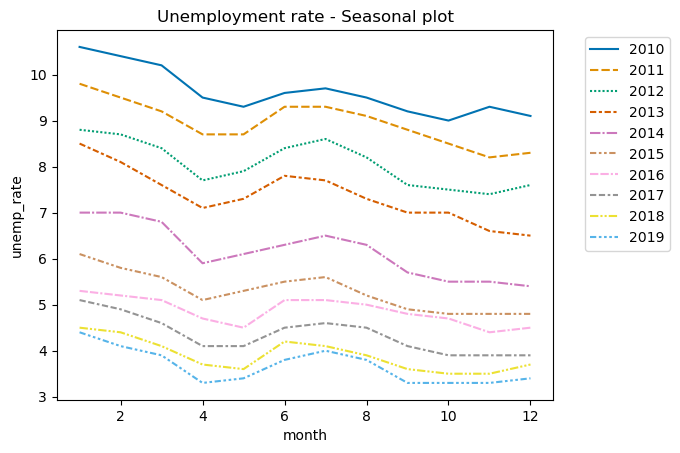

In [109]:
fig,ax = plt.subplots(1,1)
df_unem['month'] = df_unem.index.month
df_unem['year'] = df_unem.index.year

sns.lineplot(data=df_unem, 
             x="month", 
             y="unemp_rate", 
             hue="year",
             style="year", 
             legend="full",
             palette="colorblind")
plt.title("Unemployment rate - Seasonal plot")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

Both over the years and wihtin the months, the unemployment rate has some repeating patterns. I will try to model it.

### Rolling mean and standard deviation

<Axes: title={'center': 'Unemployment rate'}, xlabel='Date'>

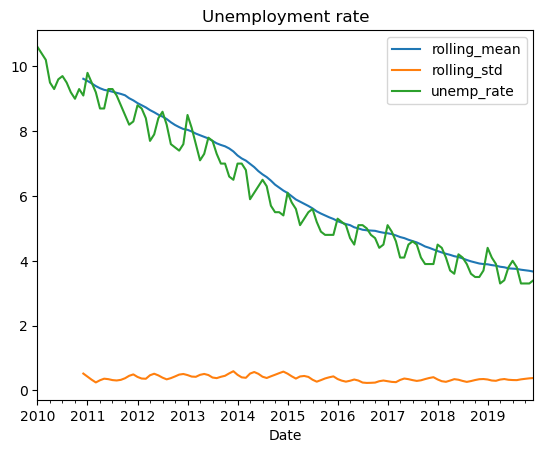

In [110]:

WINDOW_SIZE = 12
df_unem["rolling_mean"] = df_unem["unemp_rate"].rolling(window=WINDOW_SIZE).mean()
df_unem["rolling_std"] = df_unem["unemp_rate"].rolling(window=WINDOW_SIZE).std()

df_unem[["rolling_mean", "rolling_std", "unemp_rate"]].plot(title="Unemployment rate")



## Additive Seasonal Decomposition

### Components of classical seasonal decomposition

1. **Trend Component**: This represents the long-term progression or pattern in the time series, which is estimated by applying a low-pass filter to the detrended data.

2. **Seasonal Component**: This captures the repeating patterns or cycles in the data, such as monthly or quarterly fluctuations. The seasonal component is calculated first and removed to estimate the trend component. The smoothing for the seasonal component is performed separately for each subseries (e.g., each month or quarter) and then recombined.

3. **Residual Component**: Also known as the remainder, this component represents the noise or unexplained variation in the time series after removing the trend and seasonal components. It is calculated by subtracting the trend and seasonal components from the original data.

Text(0.5, 1.0, 'Unemployment Rate')

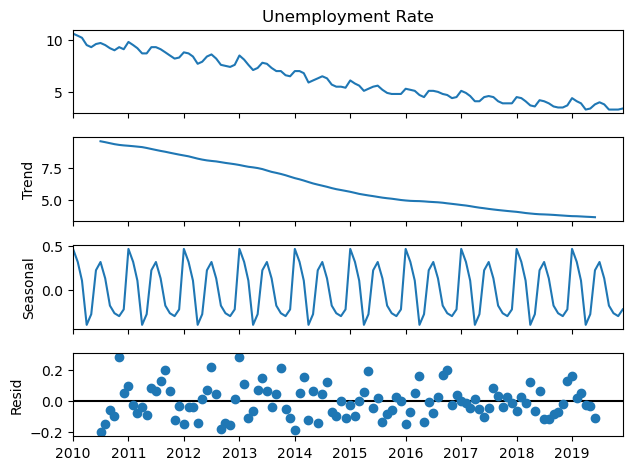

In [111]:
decomposition_results = seasonal_decompose(df_unem["unemp_rate"],
model="additive")
decomposition_results.plot().get_axes()[0].set_title('Unemployment Rate')


Looking at the distribution of residuals we can see that the mean is close to zero and it does not have a pattern, therefore the decomposition is good. The variance in the residuals is slightly higher in the first half of the dataset. This can indicate that a constant seasonal pattern is not good enough to accurately capture the seasonal component of the analyzed time series and a better model is needed. 

**Disadvantages of additive seasonal decomposition**

- As the algorithm uses centered moving averages to estimate the trend, running the decompo-
sition results in missing values of the trend line (and the residuals) at the very beginning and 
end of the time series.
-  The seasonal pattern estimated using this approach is assumed to repeat every year. It  is a very strong assumption, especially for longer time series.
-  The trend line has a tendency to over-smooth the data. 
-  The method is not robust to potential outliers in the data.

## STL decomposition


Seasonal-Trend decomposition using LOESS (STL) is a robust method for decomposing time series data into three main components: trend, seasonal, and residual (or remainder) components.

### Methodology

STL uses LOESS (locally estimated scatterplot smoothing) to perform the decomposition. The algorithm operates in two loops: the inner loop iterates between seasonal and trend smoothing, while the outer loop minimizes the effect of outliers. The seasonal component is calculated and removed first, followed by the trend component, and finally, the remainder is obtained.

### Advantages and Limitations

STL is versatile and can handle any type of seasonality, unlike other methods such as SEATS and X11, which are limited to monthly and quarterly data. It allows the seasonal component to change over time, and the rate of change can be controlled by the user. Additionally, STL is robust to outliers, ensuring that occasional unusual observations do not affect the estimates of the trend-cycle and seasonal components.

However, STL has some limitations, such as not automatically handling trading day or calendar variations and only supporting additive decompositions. Multiplicative decompositions can be achieved by transforming the data using a Box-Cox transformation.

Overall, STL decomposition is a powerful tool for analyzing time series data, allowing for the separation of underlying patterns from noise, which facilitates more accurate forecasting and analysis.



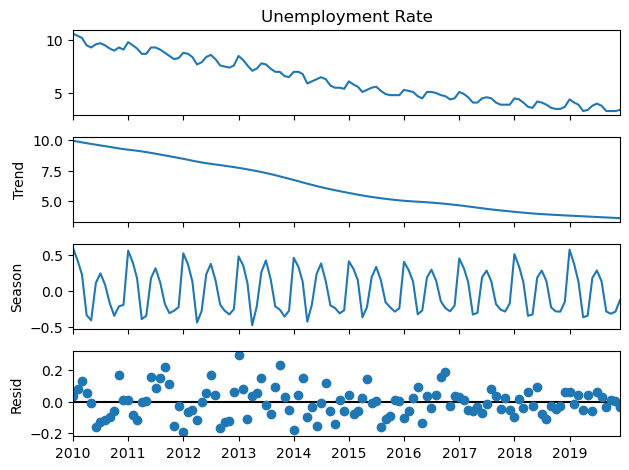

In [112]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

# Fit the STL decomposition
stl_decomposition = STL(df_unem["unemp_rate"]).fit()

# Plotting the decomposition
stl_decomposition.plot().get_axes()[0].set_title('Unemployment Rate')
plt.show()


STL and classical decompositions appear very similar. There are no missing values in the trend estimate at the beginning and end. The seasonal component is slowly changing over time. This is clear when focussing on data for one month for multiple years.

## Stationarity

The principle of weak stationarity states that for time series to be stationary: 

- The mean of the series must be constant
-  The variance of the series must be finite and constant
-  The covariance between periods of identical distance must be constant

Stationary is important when modeling the series using auto-regressive model (AR, ARMA, ARIMA, and so on). However, there are also models that do not benefit from stationary time series, for example, those that depend 
heavily on time series decomposition (exponential smoothing methods or Facebook’s Prophet).

I will use the Augmented Dickey-Fuller test to check if the data is stationary or not. The null hypothesis of the ADF test states that the time series is not stationary. The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine if a time series is stationary or non-stationary. The ADF test checks for the presence of a unit root in a time series, which indicates whether the series is stationary or not. A stationary time series is one whose statistical properties, such as the mean and variance, remain constant over time.

**How does the ADF test work?**

The ADF test is based on the following null and alternative hypotheses:

* Null hypothesis (H0): The time series has a unit root (i.e., it is non-stationary).
* Alternative hypothesis (H1): The time series does not have a unit root (i.e., it is stationary).

The test involves estimating the following regression equation:

Δy(t) = α + βt + γy(t-1) + δ1Δy(t-1) + … + δpΔy(t-p) + ε(t)

where:

* Δy(t) is the first difference of the time series
* α is a constant term
* β is the coefficient on the time trend
* γ is the coefficient on the lagged level of the time series
* δ1, …, δp are the coefficients on the lagged differences of the time series
* ε(t) is the error term

The test statistic is calculated as the ratio of the estimated coefficient on the lagged level of the time series (γ) to its standard error. The test statistic is then compared to a critical value from a distribution (usually the t-distribution).

**What do the results mean?**

If the test statistic is less than the critical value, the null hypothesis is rejected, and it is concluded that the time series is stationary. If the test statistic is greater than the critical value, the null hypothesis is not rejected, and it is concluded that the time series is non-stationary.


In [113]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss


def adf_test(x):
    
    # run the test on x
    adf_test = adfuller(x, autolag="AIC")
    # create dataframe with adf_test results
    # fill first 4 indices
    indices = ["Test Statistic", "p-value", "No. of Lags Used", "No. of Observations Used"]
    results = pd.Series(adf_test[0:4], index=indices)
    
    # 4th item gives the dictionary containing critical values
    for key, value in adf_test[4].items():
        results[f"Critical Value {key}"] = value

    return results


test_results = adf_test(df_unem["unemp_rate"])

for column in test_results.keys():

    print(f"{column} : {test_results[column]}")

if test_results['p-value']<0.05:
    print("data are stationary")
else:
    print("data is not stationary")


Test Statistic : -2.0534106333749667
p-value : 0.26365607984684175
No. of Lags Used : 12.0
No. of Observations Used : 107.0
Critical Value 1% : -3.492995948509562
Critical Value 5% : -2.888954648057252
Critical Value 10% : -2.58139291903223
data is not stationary


###  ACF/PACF plots

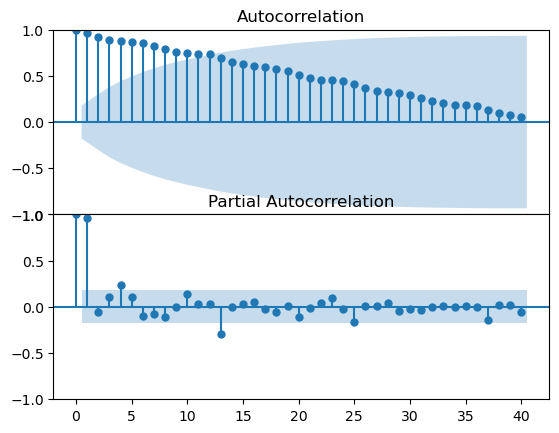

In [114]:
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05
fig, ax = plt.subplots(2, 1,sharex=True)
plot_acf(df_unem["unemp_rate"], ax=ax[0], lags=N_LAGS,alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df_unem["unemp_rate"], ax=ax[1], lags=N_LAGS,alpha=SIGNIFICANCE_LEVEL)

fig.subplots_adjust(hspace=0)
plt.show()

ACF plot shows there are significant autocorrelations (above  the 95% confidence interval, corresponding to the selected 5% significance level). There are also some significant auto-correlations at lags 1, 4 and 13 in the PACF plot.

## Exponential Smoothing


Exponential smoothing works on the principle that forecasts are simply weighted averages of past observations. When calculating those averages recent observations are given more weight. These models are suitable for non-stationary data, that is, data with a trend and/or seasonality. Different smoothing and their work cases:

- Simple Exponential Smoothing:  data does not exhibit any trend or seasonality. 
- Holt's double exponential smoothing method:  there is a trend in the data, but no seasonality.
- Holt-Winters exponential smoothing method:  there is a trend and seasonality in the data.



### Simple Exponential Smoothing

In [115]:
import pandas as pd
from datetime import date
from statsmodels.tsa.holtwinters import ExponentialSmoothing,SimpleExpSmoothing,Holt

# Do a train-test split

# set the test length to be of 12 months
TEST_LENGTH = 12

# set the frequency to be month start
df_unem.index.freq = "MS"

# split the data in train and test
df_train = df_unem.iloc[:-TEST_LENGTH]
df_test = df_unem[-TEST_LENGTH:]

In [137]:
# get simple smoothing with parameter 0.5
ses_1 = SimpleExpSmoothing(df_train['unemp_rate']).fit(smoothing_level=0.5)
# forcast from simple smoothing
ses_forecast_1 = ses_1.forecast(TEST_LENGTH)

# let the smoothing level be automatically chosen
ses_2 = SimpleExpSmoothing(df_train['unemp_rate']).fit()
# forcast
ses_forecast_2 = ses_2.forecast(TEST_LENGTH)
print('smoothing level 0.5\n',ses_1.params_formatted)
print('smoothing level auto\n',ses_2.params_formatted)

smoothing level 0.5
                   name  param  optimized
smoothing_level  alpha    0.5      False
initial_level      l.0   10.6      False
smoothing level auto
                   name  param  optimized
smoothing_level  alpha    1.0       True
initial_level      l.0   10.6      False


/home/ankit/miniconda3/envs/DS/lib/python3.11/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


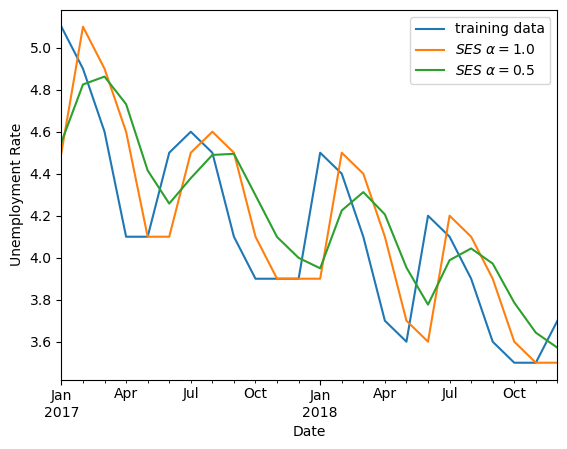

In [129]:

fig, ax = plt.subplots(1, 1)

# plot last 24 months of training and fitted values of simple smoothing
df_train['unemp_rate'].iloc[-24:].plot(ax=ax, label="training data")
ses_2.fittedvalues.iloc[-24:].plot(ax=ax, label=r"$SES \ \alpha=1.0 $")
ses_1.fittedvalues.iloc[-24:].plot(ax=ax, label=r"$SES \ \alpha=0.5 $")

ax.set( xlabel="Date", ylabel="Unemployment Rate")
ax.legend(loc="best")
plt.show()

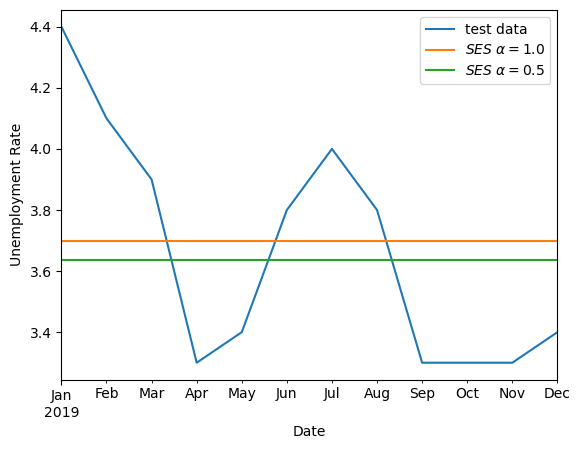

In [132]:
# Test data 

fig, ax = plt.subplots(1, 1)

# plot last 24 months of training and fitted values of simple smoothing
df_test['unemp_rate'].plot(ax=ax, label="test data")
ses_forecast_2.plot(ax=ax, label=r"$SES \ \alpha=1.0 $")
ses_forecast_1.plot(ax=ax, label=r"$SES \ \alpha=0.5 $")

ax.set( xlabel="Date", ylabel="Unemployment Rate")
ax.legend(loc="best")
plt.show()

The forecasts produced using SES are flat, that is, regardless of the time horizon, all forecasts have 
the same value (corresponding to the last level component). That is why this method is only suitable 
for series with neither trend nor seasonality.

### Holt's double exponential

In [142]:
# Holt's model with linear trend
hs_1 = Holt(df_train['unemp_rate']).fit()
hs_forecast_1 = hs_1.forecast(TEST_LENGTH)


# Holt's model with exponential trend
hs_2 = Holt(df_train['unemp_rate'], exponential=True).fit()
hs_forecast_2 = hs_2.forecast(TEST_LENGTH)


# Holt's model with exponential trend and damping
hs_3 = Holt(df_train['unemp_rate'], exponential=False,damped_trend=True).fit()
hs_forecast_3 = hs_3.forecast(TEST_LENGTH)

In [147]:
# Forecast
hs_df = df_unem['unemp_rate'].copy()
hs_df["hs_1"] = hs_1.fittedvalues.append(hs_forecast_1)
hs_df["hs_2"] = hs_2.fittedvalues.append(hs_forecast_2)
hs_df["hs_3"] = hs_3.fittedvalues.append(hs_forecast_3)

AttributeError: 'Series' object has no attribute 'append'

<Axes: xlabel='Date'>

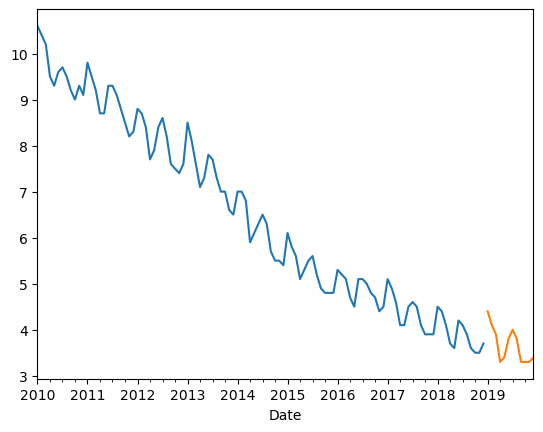

In [145]:
# Plotting

fig,ax = plt.subplots(1,1)

df_train['unemp_rate'].plot(ax=ax)
df_test['unemp_rate'].plot(ax=ax)